![](https://github.com/gialdetti/netsci/blob/master/examples/images/blue_brain_neurons.colorful.png?raw=1)

# Analyzing Connectomics Data
---
The `netsci` package comes with an out-of-box dataset describing the [neuronal network](https://en.wikipedia.org/wiki/Neural_network) among ~2,000 neurons from a rat brain. In this notebook, we shortly explain the nature of this data and demonstrate a basic network analysis applied upon it.

Essentially, after completing this tutorial, you will know:
1. What are the brain's neural networks and what is the connectome.
2. How to load the (toy) connectomics data and convert it to a network.
3. How to identify and count three-node motifs in a network.
4. That, in neuronal networks, a motif connectivity is highly related to the spatial embedding of its composing neurons.

A deeper description of this network study, together with its neuroscientific context and implication, can be found in [this recent paper](https://doi.org/10.1101/656058).


Let’s get started.


## Connectomics
> *You are more than your genes. You are your connectome.* --Sebastian Seung

The human brain is composed of about 100 billion specialized nerve cells, [**neurons**](https://en.wikipedia.org/wiki/Neuron). Neurons can connect to up to 10,000 other target neurons each, altogether forming the vast and complex [biological neural networks](https://en.wikipedia.org/wiki/Neural_circuit). The inter-connections between neurons are formed by [**synapses**](https://en.wikipedia.org/wiki/Synapse) - structural "junctions" that allow transferring electric impulses, [**action potentials**](https://en.wikipedia.org/wiki/Action_potential), from one neuron the another. The precise wiring diagram of all neuronal connections, or [**the connectome**](https://en.wikipedia.org/wiki/Connectome), shapes the network-wide electric activity and underlies the different brain functions like information processing, memory, and, ultimately, behavior. However, how exactly does the network structure affect brain activity and function, is a long-standing and still open question in neuroscience for more than a century.

<p style='text-align:center; margin: 20px 0'>
    <img src='https://cdn.kastatic.org/ka-perseus-images/ee56b2d6b187d7bb192a2127ec38561e42ac7062.png'/>
    from <a href='https://www.khanacademy.org/science/biology/human-biology/neuron-nervous-system/a/the-synapse'>www.khanacademy.org</a>
</p>

The biological connectome can be further modeled as a mathematical [**directed graph**](https://en.wikipedia.org/wiki/Directed_graph) whose [**nodes**](https://en.wikipedia.org/wiki/Glossary_of_graph_theory_terms#node) correspond to the neurons, and its [**edges**](https://en.wikipedia.org/wiki/Glossary_of_graph_theory_terms#edge) are the synaptic connections between those neurons. This network-based perspective of the brain allows utilizing tools from [**graph theory**](https://en.wikipedia.org/wiki/Graph_theory) and modern [**network science**](https://en.wikipedia.org/wiki/Network_science) to uncover key network structures that support brain functions. Such methods have already identified several network features in cortex architecture, such as the rare but highly-connected hub neurons, cliques of all-to-all connected neurons, and overall small-world topology of the cortical microcircuit.

![](https://github.com/gialdetti/netsci/blob/master/examples/images/nn.4576.sketch.reduced.png?raw=1)

Arguably, one of the most basic, yet still not fully explained, network structures observed in neuronal circuits are the 3-neuron subgraphs (triplets). When counting the frequency of all possible 3-nodes connectivity patterns in the network, the distribution appears highly unexpected. Specifically, few specific configurations (out of all 16 possible) stand-out and are significantly over-expressed (motifs) when compared with reference randomized networks. More surprisingly, different microcircuits across different brain regions commonly display similar over- and under-expression of the same motifs. However, despite their cross-region universality, both the origin of these motifs and their functional implication have remained elusive.

![](https://github.com/gialdetti/netsci/blob/master/examples/images/ANNs.cropped.png?raw=1)

**So, what is the origin of neuronal network motifs?**

In the absence of a concrete theory about the principles underlying these motifs, their emergence may be hypothetically associated with active plasticity and learning processes. But another, much more parsimonious,  possibility comes to mind. Most types of cortical neurons display highly asymmetric geometry with dendritic and axonal trees typically extending in different directions. As a consequence, the probability of forming a connection in one direction (e.g., down) may be higher than in the other direction (e.g., up). This symmetry breaking may distinctively promote some motifs while depressing others. Thus, it could be the case that the geometry per se “enforces” the complex profile of brain microcircuit motifs.

The importance of this hypothesis is that if it is indeed so, then we can now see learning processes as operating on top of an innate, already structured, cortical skeleton rather than on a _tabula rasa_ network connectivity. This will strongly constrain the degree by which plasticity could further shape neural connectivity, and possible reduce the room for learning.

We will test this hypothesis below. Toward this end, we will utilize the publicly available dataset of the [Blue Brain model](https://bbp.epfl.ch/nmc-portal/welcome). Specifically, we analyze here a subcircuit of it (pyramidal neurons for layer 5), that is now accessible via `netsci` API's.

In [ ]:
!pip install plotly
!pip install holoviews
!pip install netsci       # required, when notebook is executed in Google Colab

: 

In [2]:
import numpy as np
import pandas as pd

import holoviews as hv
from holoviews import dim, opts

import matplotlib.pyplot as plt
import seaborn as sns; # sns.set_context("paper")

from netsci.datasets import load_connectome
import netsci.metrics.motifs as nsm

hv.extension('plotly')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [3]:
plt.rcParams['figure.dpi'] = 100

## The Data

The connectome dataset is composed of two parts:
1. The *nodes* are the neurons. The data lists of all neurons, their `gid`-s and 3d position $ (x,y,z) $.
2. The *edges* depict the synapses interconnecting all neurons. The data lists all pairs of connected neurons and the number of contacts (synapses) realizing each connection.

In [4]:
connectome = load_connectome()
display({k: type(v) for k, v in connectome.items()})

{'title': str,
 'nodes': pandas.core.frame.DataFrame,
 'edges': pandas.core.frame.DataFrame}

The magnitude of the network is

In [5]:
print(connectome['title'])
neurons, synapses = connectome['nodes'], connectome['edges']

n = len(neurons)
print(f'\t{n:,} neurons\n',
      f'\t{len(synapses):,} connections (p = {len(synapses)/(n*(n-1)):.2%})\n'
      f'\t{synapses["contacts"].sum():,} contacts')

Connectome (L5-TTPC
	2,003 neurons
 	102,732 connections (p = 2.56%)
	650,949 contacts


### Neurons

In [6]:
display(neurons)

,gid,x,y,z
0,75211,341.846181,773.977844,636.437126
1,75214,305.869316,1200.585727,608.787329
2,75217,312.411025,1184.177732,647.120290
3,75218,275.261806,1110.341752,630.010095
4,75221,239.869853,880.629815,609.945456
...,...,...,...,...
1998,81314,472.198046,1087.211926,409.227347
1999,81317,308.608095,947.743964,624.308077
2000,81318,325.510390,1029.783942,574.410863
2001,81319,383.361952,1161.047906,655.450589


The *y-axis* denotes the cortical depth. The positive direction is defined to be the [_pia_](https://en.wikipedia.org/wiki/Pia_mater#Cranial_pia_mater) direction in the column.

In [8]:
# hv.Scatter3D((neurons.x, neurons.y, neurons.z)).opts(
#     opts.Scatter3D(azimuth=40, elevation=20, color='z', s=50, cmap='fire'))

hv.Scatter3D((neurons.x, neurons.y, neurons.z)) \
    .opts(cmap='fire', color='y', size=3, alpha=.75, width=800, height=800)

:Scatter3D   [x,y,z]

### Synaptic connections

In [9]:
display(synapses)

,from,to,contacts
0,75211,75221,5
1,75211,75276,5
2,75211,75473,5
3,75211,76012,7
4,75211,76095,3
...,...,...,...
102727,81322,80991,5
102728,81322,81051,5
102729,81322,81111,4
102730,81322,81116,9


### Adjaceny matrix

Although representing the network as an edge list as above might space-efficient, sometimes it is more convenient to analyze the adjacency matrix directly. You could, obviously, transform the edge list to the matrix representation yourself (a quick exercise in [table operations](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) acrobatics, or straightforward by nested loops). Still, we can simply get it using the `adjacency=True` flag as below:

In [10]:
connectome = load_connectome(adjacency=True)
neurons, synapses, A, W = connectome['nodes'], connectome['edges'], connectome['A'], connectome['W']

print(f'{A.shape[0]}x{A.shape[1]} adjacency matrix\n',
      f'\t{len(A):,} neurons\n',
      f'\t{A.sum():,} connections\n'
      f'\t{W.sum():,} contacts')

2003x2003 adjacency matrix
 	2,003 neurons
 	102,732 connections
	650,949 contacts


Note that for convenience, in addition to the binary adjacency matrix `A`, a weighted matrix `W`, whose values describe the number of synapses per connection, is also returned. For the rest of our analysis here, we consider only the connections (without the contacts).

## Motif embedding in space

### Scan triplet motifs
Let's examine the how each motif is embedded in space.

In [ ]:
tid_order = nsm.triad_order_nn4576

frequency, participations = nsm.motifs(A, participation=True)
frequency, participations = np.take(frequency, tid_order), np.take(participations, tid_order)

In [ ]:
print(frequency)

[4187617 2738360 3162677  281224  208612  174242   29961    4328    7555
    7808    6694     689      15]


In [ ]:
gids = neurons['gid'].values
motifs = pd.concat([pd.DataFrame(gids.take(p), columns=['R','G','B']).assign(motif=i+1)
                    for i, p in enumerate(participations) if p], ignore_index=True)
display(motifs)

,R,G,B,motif
0,75211,75221,75261,1
1,75211,75221,75271,1
2,75211,75221,75277,1
3,75211,75221,75396,1
4,75211,75221,75691,1
...,...,...,...,...
10809777,81129,80370,76956,13
10809778,78718,77948,77520,13
10809779,80751,79899,77546,13
10809780,80386,80335,77704,13


In [ ]:
assert np.array_equal(frequency, motifs.groupby('motif').size())

motifs.groupby('motif').size().to_frame('Frequency').T.style.format('{:,}')

motif,1,2,3,4,5,6,7,8,9,10,11,12,13
Frequency,"4,187,617","2,738,360","3,162,677","281,224","208,612","174,242","29,961","4,328","7,555","7,808","6,694",689,15


## Triplet motifs spatial embedding

Lastly, we examine the positions of the neurons forming each of the motifs. Since the pyramidal neurons are vertical, we'll focus on the y-coordinate (cortical depth).

In [ ]:
embedding = motifs \
    .merge(neurons.set_index('gid').add_prefix('R'), how='left', left_on='R', right_index=True) \
    .merge(neurons.set_index('gid').add_prefix('G'), how='left', left_on='G', right_index=True) \
    .merge(neurons.set_index('gid').add_prefix('B'), how='left', left_on='B', right_index=True)
embedding

,R,G,B,motif,Rx,Ry,Rz,Gx,Gy,Gz,Bx,By,Bz
0,75211,75221,75261,1,341.846181,773.977844,636.437126,239.869853,880.629815,609.945456,203.276337,968.822791,481.909118
1,75211,75221,75271,1,341.846181,773.977844,636.437126,239.869853,880.629815,609.945456,320.183623,1180.844858,570.809167
2,75211,75221,75277,1,341.846181,773.977844,636.437126,239.869853,880.629815,609.945456,293.199873,1090.600882,580.749479
3,75211,75221,75396,1,341.846181,773.977844,636.437126,239.869853,880.629815,609.945456,393.450029,1067.014389,642.183122
4,75211,75221,75691,1,341.846181,773.977844,636.437126,239.869853,880.629815,609.945456,497.137587,1024.840713,725.135217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10809777,81129,80370,76956,13,192.844296,948.897651,737.201974,178.475477,1061.766714,692.749867,248.743735,1104.252847,703.846591
10809778,78718,77948,77520,13,472.534544,787.782031,597.521670,385.660359,797.075622,501.540998,359.745437,878.731038,649.375373
10809779,80751,79899,77546,13,214.454828,907.813569,437.465360,226.882608,883.506021,430.744574,251.492190,1077.677984,499.352161
10809780,80386,80335,77704,13,335.823705,1079.200210,626.482609,340.106908,1018.695726,604.070499,337.106262,998.329943,660.917740


Text(0, 0.5, 'Height (µm)')

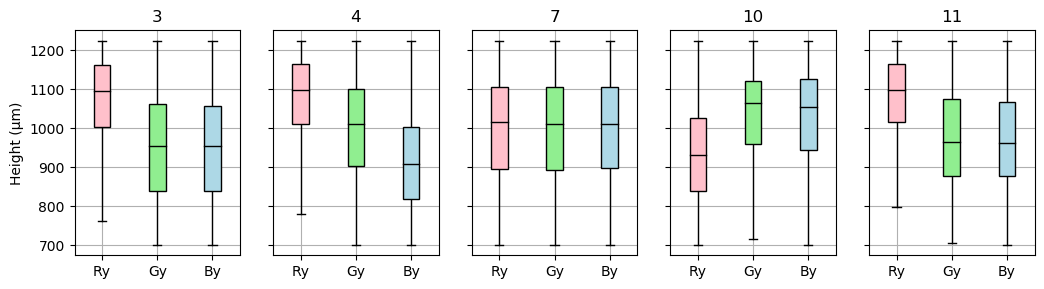

In [ ]:
motifs_order = [3, 4, 7, 10, 11]

axes = embedding[embedding['motif'].isin(motifs_order)].groupby('motif') \
    .boxplot(column=['Ry', 'Gy', 'By'], layout=(1, len(motifs_order)), figsize=(12,3),
             showfliers=False, patch_artist=True, boxprops=dict())

colors = ['pink', 'lightgreen', 'lightblue']
for ax in axes.values:
    plt.setp(ax.lines, color='k')
    [patch.set(edgecolor='k', facecolor=color) for patch, color in zip(ax.artists, colors)]

axes.values[0].set_ylabel('Height (µm)')


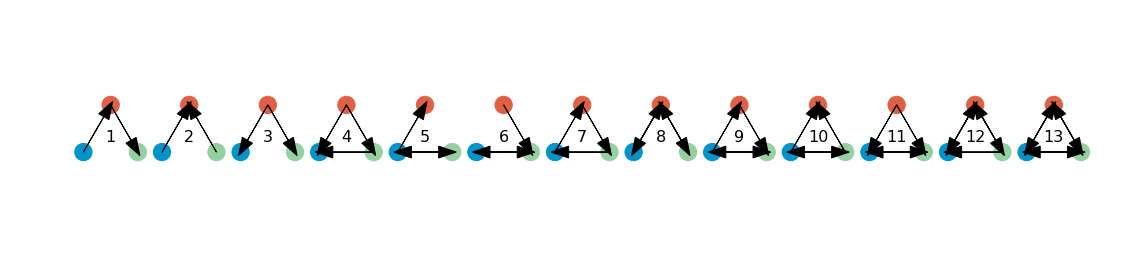

The analysis uncovers a close match between the physical positions of the neurons and the synaptic connectivity they form. For instance, for motif #4 the “source” neuron (the presynaptic neuron that projects to the other two) is located, on average, above the other two cells whereas the “sink” neuron (the postsynaptic neuron receiving projections from the other two) is, on average, the lowest.

## References and Further Readings
Books
1. [Networks of the Brain](https://mitpress.mit.edu/books/networks-brain#:~:targetText=In%20Networks%20of%20the%20Brain%2C%20Olaf%20Sporns%20describes%20how%20the,from%20a%20complex%20network%20perspective.&targetText=Networks%20of%20the%20Brain%20provides,essential%20foundation%20for%20future%20research.) by [Olaf Sporns](http://twitter.com/spornslab)
2. [Connectome](http://connectomethebook.com/) by [Sebastian Seung](http://seunglab.org/)

Papers
* Markram, Muller, Ramaswamy, Reimann, Abdellah, Sanchez et al. (2015). [Reconstruction and Simulation of Neocortical Microcircuitry](https://www.cell.com/fulltext/S0092-8674(15)01191-5). *Cell*, **163**, 456–492. https://doi.org/10.1016/j.cell.2015.09.029.
    * The _in silico_ digital reconstruction of the network of all synaptic connections in a cortical microcircuit.
* Gal, London, Globerson, Ramaswamy, Reimann, Muller, Markram, and Segev. (2017). [Rich cell-type-specific network topology in neocortical microcircuitry](http://www.rdcu.be/tffO). *Nat Neurosci*, **20(7)**, 1004–1013. http://doi.org/10.1038/nn.4576.
    * A network science analysis of the cortical microcircuit.
* Gal, Perin, Markram, London, and Segev. (2019). [Neuron Geometry Underlies a Universal Local Architecture in Neuronal Networks](https://doi.org/10.1101/656058). *bioRxiv*, 656058. https://doi.org/10.1101/656058.
    * Developing a general framework for spatially embedded networks that, when applied to biological neuronal networks, uncovers the geometric origin of network motifs universally emergence in different brain regions.

Web resources
1. [The neuron and nervous system](https://www.khanacademy.org/science/biology/human-biology#neuron-nervous-system). From the inspiring [Khan Academy](https://www.khanacademy.org/).
2. [Blue Brain's portal](https://bbp.epfl.ch/nmc-portal/welcome).